
# SWOT–ICESat-2 Matching Notebook

This notebook performs the co-location and analysis of **SWOT** (Surface Water and Ocean Topography) and **ICESat-2** (ATL03) passes over sea ice.
It includes:
- Data loading and filtering  
- Temporal and spatial matching  
- Interpolation of geophysical corrections  
- Visualization and analysis of matched data


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr
import os
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cmocean.cm as cmo
from scipy.interpolate import griddata
import rasterio
from rasterio.transform import from_bounds, from_origin
import geopandas as gpd
from shapely.geometry import Point
from shapely.geometry import Polygon, MultiPoint
from matplotlib.colors import ListedColormap, BoundaryNorm
from shapely import wkt

import sys
sys.path.append("..")
from src.utils.Is2_utils import get_beam_strengths,load_ATL07_tracks, load_ATL07_file,load_ATL03_file_with_interp,find_colocated_ATL_files,apply_moving_average
from src.utils.swot_utils import crop_swot_dataset, load_unsmoothed_swot, interpolate_unsmoothed, apply_ssha_corrections, colocate_swot_is2_tracks, save_field_as_xyz




## Configuration and Setup

Below we load necessary Python packages and read configuration files defining the area of interest (AOI), date range, and download paths.


In [2]:
#DATA DIRECTORIES

ATL03_dir = "/home/framo4051/Documents/UIT/sea_ice_features/data/IS2/ATL03"
SWOT_expert_dir = "/home/framo4051/Documents/UIT/sea_ice_features/data/SWOT/L2_LR_SSH_2.0/expert_cropped"
SWOT_unsmoothed_dir = "/home/framo4051/Documents/UIT/sea_ice_features/data/SWOT/L2_LR_SSH_2.0/Unsmoothed_cropped"


In [3]:
#Read the atl03 "index" table

is2_03_table = pd.read_csv(
    os.path.join(ATL03_dir, "ICESat2_tracks.csv")
)

is2_03_table["date"] = pd.to_datetime(is2_03_table["date"], format="%Y-%m-%d %H:%M:%S")
is2_03_table = is2_03_table.sort_values(by="date").reset_index(drop=True)
is2_03_table["filepath"] = is2_03_table["filename"].apply(lambda x: os.path.join(ATL03_dir, x))
#add _atl03 sufix on all atributes
is2_03_table = is2_03_table.add_suffix("_atl03")


In [4]:
#load swot tables and match expert with unsmoothed
# Load expert SWOT table
swot_expert_table = pd.read_csv(
    os.path.join(SWOT_expert_dir, "swot_table.csv")
)
swot_expert_table["start_time"] = pd.to_datetime(swot_expert_table["start_time"], format="%Y-%m-%d %H:%M:%S")
swot_expert_table["end_time"] = pd.to_datetime(swot_expert_table["end_time"], format="%Y-%m-%d %H:%M:%S")
swot_expert_table = swot_expert_table.sort_values(by="start_time")
swot_expert_table["file_path"] = swot_expert_table["file_path"].apply(lambda x: os.path.join("..", x))
swot_expert_table.reset_index(drop=True, inplace=True)

# Load unsmoothed SWOT table
swot_unsmoothed_table = pd.read_csv(
    os.path.join(SWOT_unsmoothed_dir, "swot_table.csv")
)
swot_unsmoothed_table["start_time"] = pd.to_datetime(swot_unsmoothed_table["start_time"], format="%Y-%m-%d %H:%M:%S")
swot_unsmoothed_table["end_time"] = pd.to_datetime(swot_unsmoothed_table["end_time"], format="%Y-%m-%d %H:%M:%S")
swot_unsmoothed_table = swot_unsmoothed_table.sort_values(by="start_time")
swot_unsmoothed_table["file_path"] = swot_unsmoothed_table["file_path"].apply(lambda x: os.path.join("..", x))
swot_unsmoothed_table.reset_index(drop=True, inplace=True)


swot_merged = pd.merge(
    swot_expert_table[['cycle', 'pass','start_time', 'end_time', 'file_path', 'polygon_wkt','direction']],
    swot_unsmoothed_table[['cycle', 'pass','start_time', 'end_time', 'file_path', 'polygon_wkt', 'direction']],
    on=['cycle', 'pass'],
    suffixes=('_expert', '_unsmoothed')
)

#should be 0.... or very very close hehe, if not, very bad!
swot_merged["diff_time"] = (swot_merged["start_time_expert"] - swot_merged["start_time_unsmoothed"]).dt.total_seconds()

#just for the northern hemisphere, hight latitudes, 
swot_merged["time_swot"] = np.where(
    swot_merged["direction_expert"] == "descending",
    swot_merged["start_time_expert"],
    swot_merged["end_time_expert"]
)


## Load SWOT and ICESat-2 Index Tables

This section loads precomputed CSV tables containing metadata and geometries (WKT polygons) for SWOT and ICESat-2 datasets.
These tables were generated by `swot_table.py` and `is2_table.py`.


In [21]:

# build GeoDataFrames directly from WKT
gdf_swot = gpd.GeoDataFrame(
    swot_merged.copy(),
    geometry=gpd.GeoSeries.from_wkt(swot_merged['polygon_wkt_unsmoothed']),
    crs='EPSG:4326'
)
gdf_is2 = gpd.GeoDataFrame(
    is2_03_table.copy(),
    geometry=gpd.GeoSeries.from_wkt(is2_03_table['geometry_wkt_atl03']),
    crs='EPSG:4326'
)

# spatial join (intersects)
matching_pairs = gpd.sjoin(
    gdf_is2,
    gdf_swot,
    how='inner',
    predicate='intersects'
).reset_index(drop=True)



# time window filter & tidy columns
window_hours = 1.5
matching_pairs = matching_pairs[
    (matching_pairs['date_atl03'] - matching_pairs['time_swot']).abs() <= pd.Timedelta(hours=window_hours)
].copy()



matching_pairs['time_delta'] = (matching_pairs['date_atl03'] - matching_pairs['time_swot']).abs()
matching_pairs = matching_pairs.sort_values('time_delta').reset_index(drop=True)

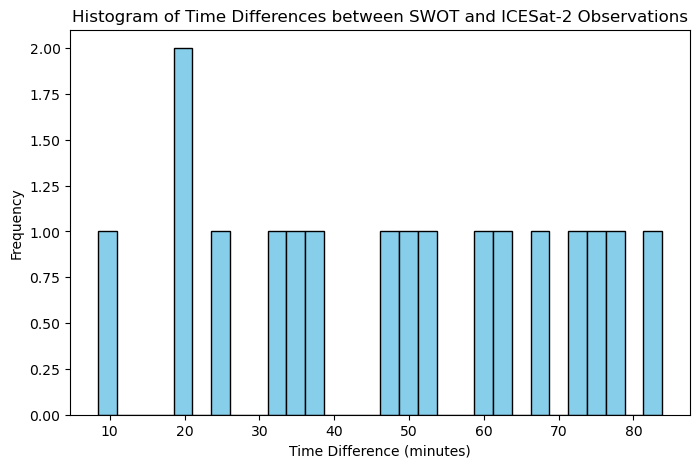

In [22]:
#histogram of time differences just to see
plt.figure(figsize=(8,5))
plt.hist(matching_pairs['time_delta'].dt.total_seconds()/60, bins=30, color='skyblue', edgecolor='black')
plt.title('Histogram of Time Differences between SWOT and ICESat-2 Observations')
plt.xlabel('Time Difference (minutes)')
plt.ylabel('Frequency')
plt.show()

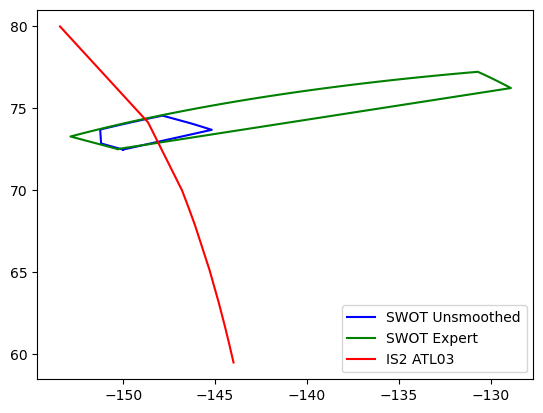

In [24]:
sample = matching_pairs.iloc[3]

geom_unsmoothed = wkt.loads(sample['polygon_wkt_unsmoothed'])
geom_expert = wkt.loads(sample['polygon_wkt_expert'])
geom_is2 = wkt.loads(sample['geometry_wkt_atl03'])

plt.Figure(figsize=(10,10))
plt.plot(*geom_unsmoothed.exterior.xy, color='blue', label='SWOT Unsmoothed')
plt.plot(*geom_expert.exterior.xy, color='green', label='SWOT Expert')
plt.plot(*geom_is2.xy, color='red', label='IS2 ATL03')
plt.legend()    


## SWOT–ICESat-2 Temporal and Spatial Matching

Here we identify matching passes between SWOT (Unsmoothed + Expert) and ICESat-2 ATL03 based on their geometry and acquisition time.


In [25]:

colocated_files = matching_pairs.iloc[1]

#inerpolate and process swot data
expert_ds = crop_swot_dataset(xr.open_dataset(colocated_files["file_path_expert"]))
unsmoothed_ds = crop_swot_dataset(xr.open_dataset(colocated_files["file_path_unsmoothed"]))

vars_to_interpolate = [
    "ssh_karin_2","solid_earth_tide" , "ocean_tide_fes" , "ocean_tide_non_eq" , "internal_tide_hret" , "pole_tide" , "dac","height_cor_xover"
    ]

# Interpolate expert fields to target grid
unsmoothed_ds = interpolate_unsmoothed(expert_ds, unsmoothed_ds, vars_to_interpolate)

# Compute SSHA using a custom MSS field, and return both HR and LR versions
ssha_HR, ssha_LR = apply_ssha_corrections(unsmoothed_ds, return_expert=True)
unsmoothed_ds["tidal_corrections"] = unsmoothed_ds["solid_earth_tide_expert"] - unsmoothed_ds["ocean_tide_fes_expert"] - \
        unsmoothed_ds["ocean_tide_non_eq_expert"] - unsmoothed_ds["internal_tide_hret_expert"] - unsmoothed_ds["pole_tide_expert"] - unsmoothed_ds["dac_expert"]

unsmoothed_ds["ssha_HR"] = ssha_HR
unsmoothed_ds["ssha_LR"] = ssha_LR

print("Loading ATL03 data...")
#open ATL03 data
atl03_ds = load_ATL03_file_with_interp(colocated_files["filepath_atl03"],colocated_files["date_atl03"])

atl03_ds["ssha"] = atl03_ds["height"] - atl03_ds["geoid"] - atl03_ds["dac"] - atl03_ds["tide_ocean"] - atl03_ds["load_tide"]


Interpolating 'ssh_karin_2' → unsmoothed grid
Interpolating 'solid_earth_tide' → unsmoothed grid
Interpolating 'ocean_tide_fes' → unsmoothed grid
Interpolating 'ocean_tide_non_eq' → unsmoothed grid
Interpolating 'internal_tide_hret' → unsmoothed grid
Interpolating 'pole_tide' → unsmoothed grid
Interpolating 'dac' → unsmoothed grid
Interpolating 'height_cor_xover' → unsmoothed grid
Interpolating 'wet_tropo_cor' → unsmoothed grid
Loading ATL03 data...


In [69]:
atl03_ds

,latitude,longitude,height,delta_time,signal_conf_land,signal_conf_ocean,signal_conf_seaice,filepath,quality,beam,beam_type,geoid,dac,tide_ocean,load_tide,date,distance_x,ssha
0,69.875984,-139.483597,-3.056308,1.983763e+08,-1,4,4,/home/framo4051/Documents/UIT/sea_ice_features...,0,gt1r,strong,-2.686938,-0.067512,0.079768,-0.000143,2024-04-15 00:29:03,7794401.5,-0.381483
1,69.875984,-139.483597,-2.709305,1.983763e+08,-1,4,4,/home/framo4051/Documents/UIT/sea_ice_features...,0,gt1r,strong,-2.686938,-0.067512,0.079768,-0.000143,2024-04-15 00:29:03,7794401.5,-0.034481
2,69.875984,-139.483597,-3.049641,1.983763e+08,-1,4,4,/home/framo4051/Documents/UIT/sea_ice_features...,0,gt1r,strong,-2.686938,-0.067512,0.079768,-0.000143,2024-04-15 00:29:03,7794401.5,-0.374816
3,69.875984,-139.483597,-2.736780,1.983763e+08,-1,4,4,/home/framo4051/Documents/UIT/sea_ice_features...,0,gt1r,strong,-2.686938,-0.067512,0.079768,-0.000143,2024-04-15 00:29:03,7794401.5,-0.061956
4,69.875992,-139.483597,-2.831096,1.983763e+08,-1,4,4,/home/framo4051/Documents/UIT/sea_ice_features...,0,gt1r,strong,-2.686948,-0.067513,0.079768,-0.000143,2024-04-15 00:29:03,7794402.5,-0.156261
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13430453,78.022919,-143.785767,-4.103641,1.983764e+08,-1,4,4,/home/framo4051/Documents/UIT/sea_ice_features...,0,gt3l,weak,-3.936545,0.125063,0.016288,-0.000741,2024-04-15 00:29:03,8712684.0,-0.307707
13430454,78.022926,-143.785767,-3.968409,1.983764e+08,-1,4,4,/home/framo4051/Documents/UIT/sea_ice_features...,0,gt3l,weak,-3.936541,0.125064,0.016288,-0.000741,2024-04-15 00:29:03,8712684.0,-0.172479
13430455,78.022934,-143.785767,-3.971292,1.983764e+08,-1,4,4,/home/framo4051/Documents/UIT/sea_ice_features...,0,gt3l,weak,-3.936537,0.125064,0.016288,-0.000741,2024-04-15 00:29:03,8712685.0,-0.175366
13430456,78.022934,-143.785767,-3.950142,1.983764e+08,-1,4,4,/home/framo4051/Documents/UIT/sea_ice_features...,0,gt3l,weak,-3.936537,0.125064,0.016288,-0.000741,2024-04-15 00:29:03,8712685.0,-0.154216


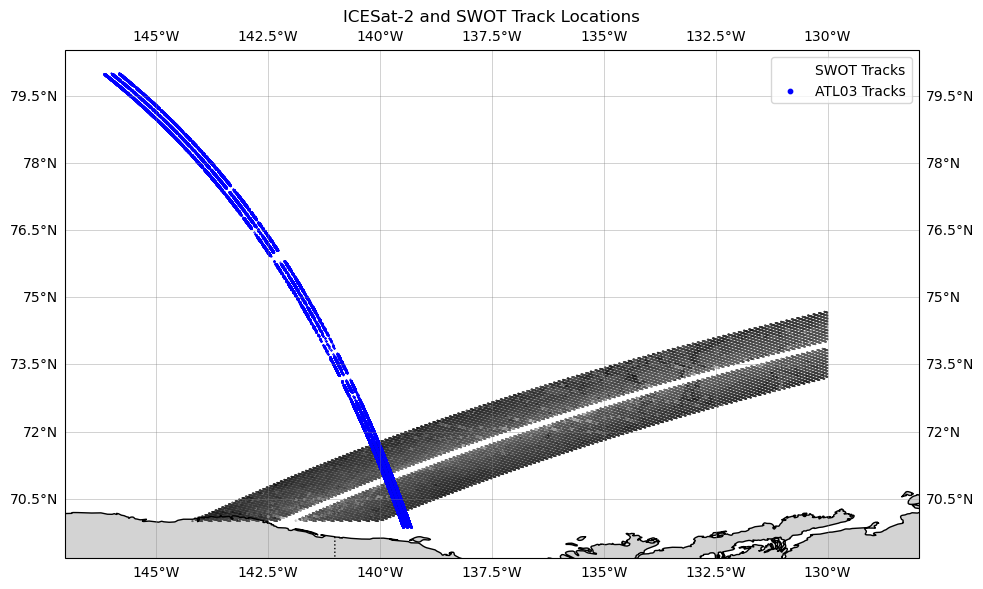

In [26]:
# Create figure and map projection
fig = plt.figure(figsize=(12, 6))
ax = plt.axes(projection=ccrs.PlateCarree())

# Add map features
ax.coastlines(resolution='10m')
ax.add_feature(cfeature.LAND, facecolor='lightgray')
ax.add_feature(cfeature.OCEAN, facecolor='white')
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5)


#scatter ionly latitude and longitude


# Plot SWOT data
ax.scatter(
    unsmoothed_ds['longitude'][::20], unsmoothed_ds['latitude'][::20],
    s=0.1, c=np.log(unsmoothed_ds["sig0_karin_2"][::20]), label='SWOT Tracks',cmap="gray",
    transform=ccrs.PlateCarree()
)

# Plot ICESat-2 ATL03 data
ax.scatter(
    atl03_ds['longitude'][::100], atl03_ds['latitude'][::100],
    s=0.1, color='blue', label='ATL03 Tracks',
    transform=ccrs.PlateCarree()
)



# Add legend and title
plt.legend(markerscale=10)
plt.title("ICESat-2 and SWOT Track Locations")
plt.tight_layout()
plt.show()


In [27]:
# Define CRS
wgs84 = "EPSG:4326"           # original CRS (lat/lon)
projected_crs = "EPSG:3413"   # polar projection 

# Extract lon/lat values from SWOT swath dataset
lons = unsmoothed_ds['longitude'].values
lats = unsmoothed_ds['latitude'].values

# Flatten in case of 2D swath (common in SWOT data)
if lons.ndim > 1:
    lons = lons.flatten()
    lats = lats.flatten()

# Remove NaNs if any
valid_mask = ~np.isnan(lons) & ~np.isnan(lats)
lons = lons[valid_mask]
lats = lats[valid_mask]

# Create swath polygon using convex hull
swath_polygon = MultiPoint(list(zip(lons, lats))).convex_hull



# Create GeoDataFrames with WGS84 CRS
atl03_gds = gpd.GeoDataFrame(
    atl03_ds, 
    geometry=gpd.points_from_xy(atl03_ds['longitude'], atl03_ds['latitude']),
    crs=wgs84
)


# Reproject both datasets and swath polygon to a projected CRS
atl03_gds = atl03_gds.to_crs(projected_crs)
swath_polygon_proj = gpd.GeoSeries([swath_polygon], crs=wgs84).to_crs(projected_crs).iloc[0]


# Select colocated points within SWOT swath
atl03_colocated = atl03_gds[atl03_gds.geometry.within(swath_polygon_proj)].to_crs(wgs84)


#print shapes for sanity check
print(f"ATL03 Colocated Points: {atl03_colocated.shape[0]}")


ATL03 Colocated Points: 3857743



## Colocation and Analysis

After matching passes, we interpolate geophysical variables, apply corrections, and compare height/SSH anomalies between SWOT and ICESat-2.


In [35]:
from sklearn.neighbors import BallTree

# Flatten and filter valid SWOT points
lat = unsmoothed_ds["latitude"].values.flatten()
lon = unsmoothed_ds["longitude"].values.flatten()
ssha = unsmoothed_ds["ssha_HR"].values.flatten()
mssh = unsmoothed_ds["mean_sea_surface_cnescls"].values.flatten()
ssh = unsmoothed_ds["ssh_karin_2"].values.flatten()
xor = unsmoothed_ds.height_cor_xover_expert.values.flatten()
tidal_corrections = unsmoothed_ds["tidal_corrections"].values.flatten()
sig0 = unsmoothed_ds["sig0_karin_2"].values.flatten()

valid_mask = np.isfinite(lat) & np.isfinite(lon) & np.isfinite(ssha)
lat, lon, ssha, mssh, ssh,xor,tidal_corrections,sig0 = [arr[valid_mask] for arr in (lat, lon, ssha, mssh, ssh,xor, tidal_corrections,sig0)]

# Convert to radians
swot_rad = np.deg2rad(np.column_stack((lat, lon)))
is2_rad = np.deg2rad(np.column_stack((atl03_colocated["latitude"].values,
                                      atl03_colocated["longitude"].values)))

# Nearest neighbor search
tree = BallTree(swot_rad, metric='haversine')
dist_rad, idx = tree.query(is2_rad, k=1)
dist_m = dist_rad.flatten() * 6371000  # Convert to meters
idx = idx.flatten()

# Match values
matched = {
    "closest_ssha": ssha[idx],
    "distance_swot": dist_m,
    "is2_swot_diff": atl03_colocated["ssha"].values - ssha[idx],
    "swot_lats": lat[idx],
    "swot_lons": lon[idx],
    "swot_mssh": mssh[idx],
    "closest_swot_ssh": ssh[idx],
    "xor": xor[idx],
    "tidal_corrections": tidal_corrections[idx],
    "sig0": sig0[idx],
}

# Mask far matches
too_far = dist_m > 200
for key in matched:
    matched[key][too_far] = np.nan

# Merge into IS2 DataFrame
colocated_tracks = atl03_colocated.copy()
for key, values in matched.items():
    colocated_tracks[key] = values

# Sort by time
colocated_tracks = colocated_tracks.sort_values(by="delta_time")

colocated_tracks["distance_x"] = (
    colocated_tracks.groupby("beam")["distance_x"]
    .transform(lambda x: (x - x.min()) / 1000)
)

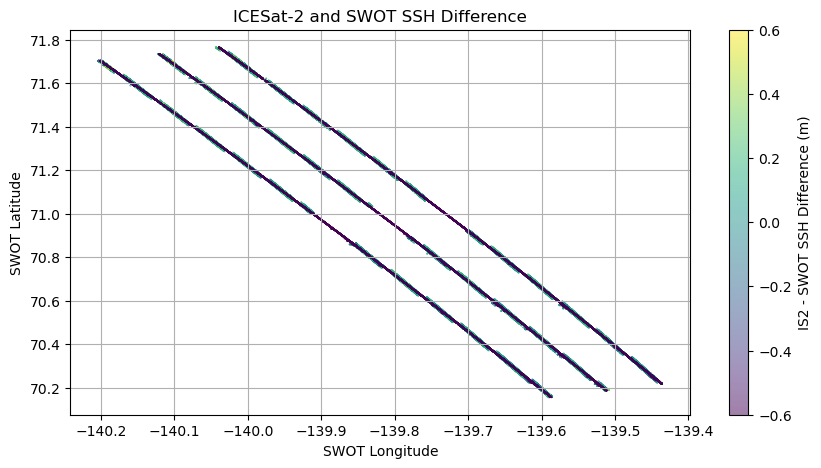

In [29]:
plt.figure(figsize=(10, 5))
plt.scatter(colocated_tracks["swot_lons"][::50], colocated_tracks["swot_lats"][::50], c=colocated_tracks["closest_ssha_HR"][::50], cmap="viridis", s=.1, vmax=.6,vmin=-.6)
plt.scatter(colocated_tracks["longitude"][::50], colocated_tracks["latitude"][::50], c=colocated_tracks["height"][::50], s=.1, alpha=0.5, label="ICESat-2 Points", vmax=.6, vmin=-.6)
plt.colorbar(label="IS2 - SWOT SSH Difference (m)")
plt.xlabel("SWOT Longitude")
plt.ylabel("SWOT Latitude")
plt.title("ICESat-2 and SWOT SSH Difference")
plt.grid()
plt.show()

In [38]:
colocated_tracks["distance_x"] = (
    colocated_tracks.groupby("beam")["distance_x"]
    .transform(lambda x: (x - x.min()) / 1000)
)

In [39]:
colocated_tracks.keys()

Index(['latitude', 'longitude', 'height', 'delta_time', 'signal_conf_land',
       'signal_conf_ocean', 'signal_conf_seaice', 'filepath', 'quality',
       'beam', 'beam_type', 'geoid', 'dac', 'tide_ocean', 'load_tide', 'date',
       'distance_x', 'ssha', 'geometry', 'closest_ssha', 'distance_swot',
       'is2_swot_diff', 'swot_lats', 'swot_lons', 'swot_mssh',
       'closest_swot_ssh', 'xor', 'tidal_corrections', 'sig0'],
      dtype='object')

In [46]:
#play with custom ssha calculations ????
#colocated_tracks["custom_ssha_is2"] = colocated_tracks.height.values - colocated_tracks.geoid.values- colocated_tracks.swot_mssh.values - colocated_tracks.tidal_corrections.values
#colocated_tracks["custom_ssha_swot"] = colocated_tracks.closest_swot_ssh.values + colocated_tracks.xor.values - colocated_tracks.swot_mssh.values - colocated_tracks.tidal_corrections.values
colocated_tracks = apply_moving_average(colocated_tracks, column='ssha', window=500, group_by='beam')


1238171 strong
999143 strong
1236238 strong


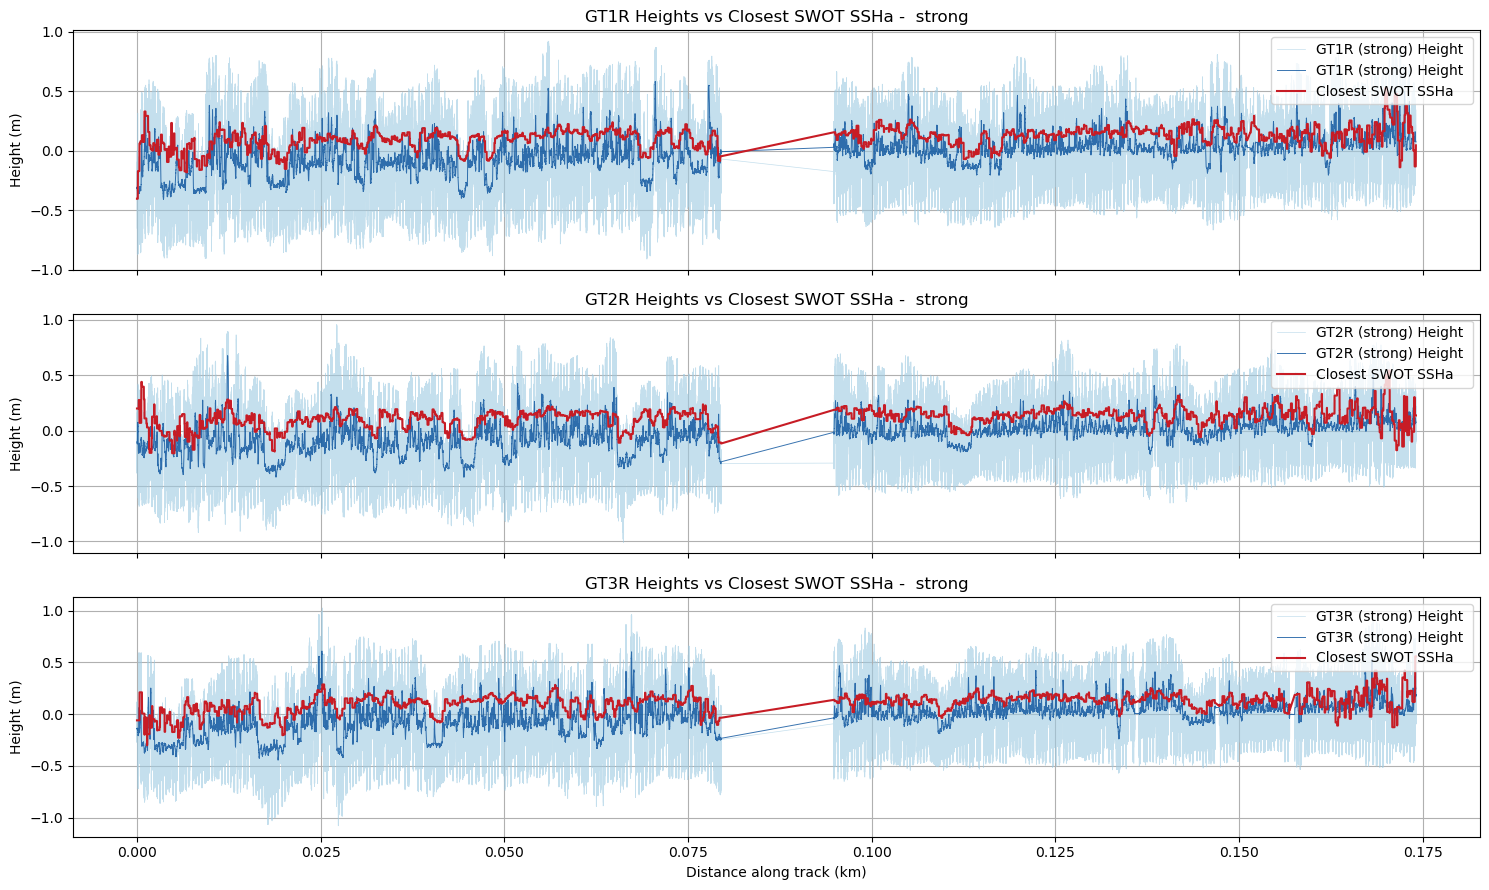

In [ ]:
#only strong beams

available_beams = colocated_tracks[colocated_tracks["beam_type"] == "strong"].beam.dropna().unique()



# Create subplots
fig, axes = plt.subplots(len(available_beams), 1, figsize=(15, 3 * len(available_beams)),sharex=True)

# If only one beam, axes isn't a list — fix that
if len(available_beams) == 1:
    axes = [axes]

# Loop over available beams
for i, beam in enumerate(available_beams[:]):
    ax = axes[i]
    gt = colocated_tracks.where(colocated_tracks["beam"] == beam).dropna()

    if len(gt) == 0:
        ax.set_title(f"{beam.upper()} — No data")
        ax.axis("off")
        continue

    beam_type = gt["beam_type"].values[0]

    #take only a subset of the data
    print(len(gt),beam_type)

    

    ax.plot(gt["distance_x"].values, gt.ssha.values, label=f"{beam.upper()} ({beam_type}) Height ",lw=.5, alpha=0.6, c="#9ecae1")
    ax.plot(gt["distance_x"].values,gt.ssha_smoothed.values, label=f"{beam.upper()} ({beam_type}) Height ",lw=.7, alpha=.8, c="#08519c")
    ax.plot(gt["distance_x"].values,gt.closest_ssha.values,label="Closest SWOT SSHa",lw=1.5, c="#c71c25")

    ax.set_ylabel("Height (m)")
    ax.set_title(f"{beam.upper()} Heights vs Closest SWOT SSHa -  {beam_type}")
    ax.grid()
    ax.legend(loc="upper right")

axes[-1].set_xlabel("Distance along track (km)")
#plt.suptitle("ICESat-2 Heights vs Closest SWOT SSHa", fontsize=12)
plt.tight_layout()
plt.show()

1238171 
999143 
1236238 


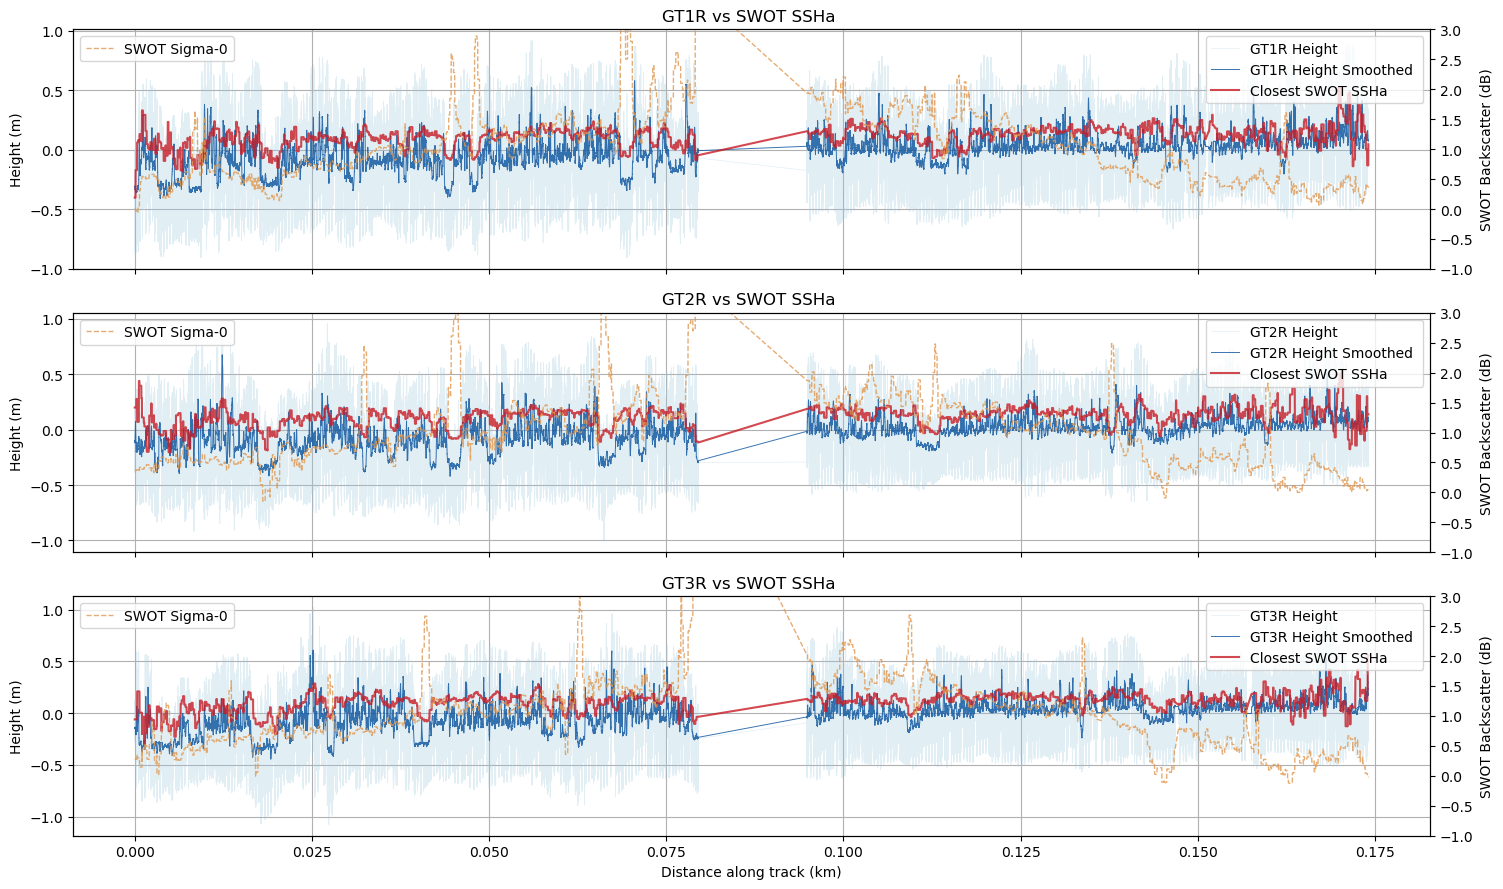

In [47]:
#only quality flag 1 or 2
#only strong beams

available_beams = colocated_tracks[colocated_tracks["beam_type"] == "strong"].beam.dropna().unique()



# Create subplots
fig, axes = plt.subplots(len(available_beams), 1, figsize=(15, 3 * len(available_beams)),sharex=True)

# If only one beam, axes isn't a list — fix that
if len(available_beams) == 1:
    axes = [axes]

# Loop over available beams
for i, beam in enumerate(available_beams[:]):
    ax = axes[i]
    gt = colocated_tracks.where(colocated_tracks["beam"] == beam).dropna()

    if len(gt) == 0:
        ax.set_title(f"{beam.upper()} — No data")
        ax.axis("off")
        continue

    beam_type = ""#gt["beam_type"].values[0]

    #take only a subset of the data
    print(len(gt),beam_type)


    ax.plot(gt["distance_x"].values,gt["ssha"].values, label=f"{beam.upper()} Height ",lw=.5, alpha=0.3, c="#9ecae1")
    ax.plot(gt["distance_x"].values,gt["ssha_smoothed"].values, label=f"{beam.upper()} Height Smoothed ",lw=.7, alpha=.8, c="#08519c")
    ax.plot(gt["distance_x"].values,gt["closest_ssha"].values, label="Closest SWOT SSHa",lw=1.5, c="#c71c25",alpha=.8)

    ax.set_ylabel("Height (m)")
    ax.set_title(f"{beam.upper()} vs SWOT SSHa ")
    ax.grid()
    ax.legend(loc="upper right")

    #secondary axis
    ax2 = ax.twinx()
    ax2.plot(gt["distance_x"].values, np.log(gt.sig0.values), label="SWOT Sigma-0", lw=1, c="#e09851", linestyle='--',alpha=.8)
    ax2.set_ylabel("SWOT Backscatter (dB)")
    ax2.grid(False)
    ax2.legend(loc="upper left")
    ax2.set_ylim(-1, 3)

axes[-1].set_xlabel("Distance along track (km)")
#plt.suptitle("ICESat-2 Heights vs Closest SWOT SSHa", fontsize=12)
plt.tight_layout()
plt.show()

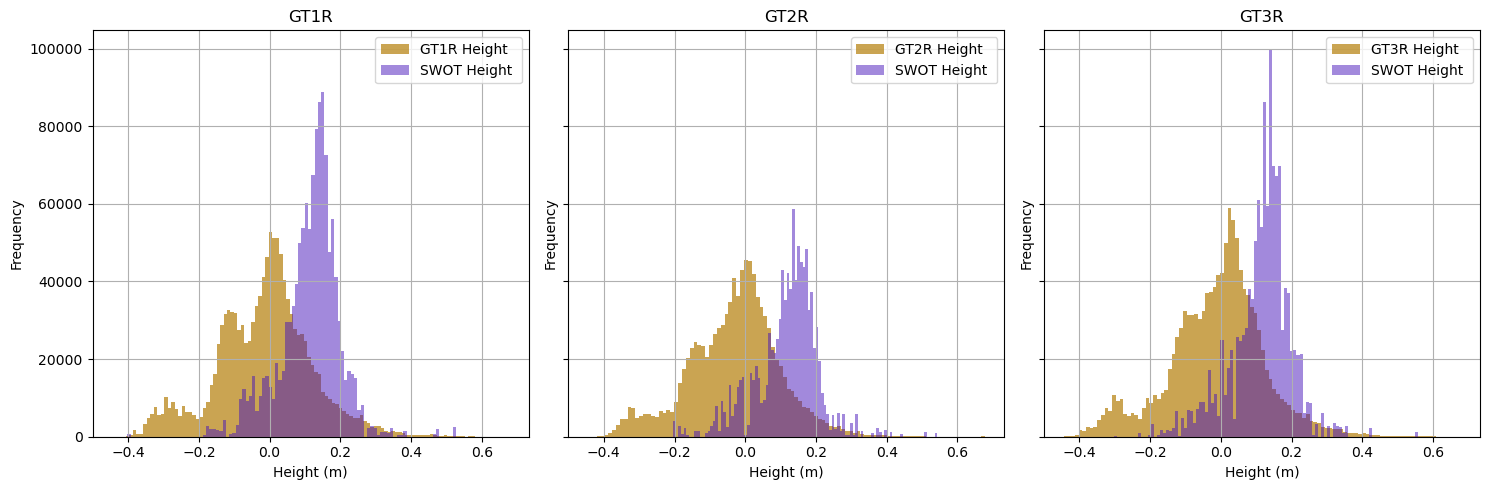

In [48]:


# Create subplots
fig, axes = plt.subplots(1,3,figsize=(15,5),sharey=True, sharex=True)
# If only one beam, axes isn't a list — fix that
if len(available_beams) == 1:
    axes = [axes]

# Loop over available beams
for i, beam in enumerate(available_beams[:]):

    gt = colocated_tracks.where(colocated_tracks["beam"] == beam).dropna()

    if len(gt) == 0:
        ax.set_title(f"{beam.upper()} — No data")
        ax.axis("off")
        continue

    beam_type = gt["beam_type"].values[0]

    #take only a subset of the data
    ax = axes[i]

    ax.hist(gt.ssha_smoothed.values,label=f"{beam.upper()} Height ", bins=100, alpha=0.7, color="#b47e09")
    ax.hist(gt.closest_ssha.values,label=f"SWOT Height ", bins=100, alpha=0.5, color="#4614bb")
    ax.set_ylabel("Frequency")
    ax.set_xlabel("Height (m)")
    ax.set_title(f"{beam.upper()}")
    ax.grid()
    ax.legend()



#share ylabel for 3 subplots
#plt.suptitle("Height Distributions for Colocated Tracks", fontsize=16)
plt.tight_layout()



In [ ]:
#gradient of ssha field --> somewhart deformation????
ssha = unsmoothed_ds["ssha_HR"]  # 2D SSH field
lat2d = unsmoothed_ds["latitude"]  # 2D
lon2d = unsmoothed_ds["longitude"]  # 2D

# Convert to radians
lat_rad = np.deg2rad(lat2d)
lon_rad = np.deg2rad(lon2d)

# Earth radius
R = 6371000  # meters

# Compute grid spacing in meters
dlat = np.gradient(lat_rad, axis=0)  # 
dlon = np.gradient(lon_rad, axis=1)  # 

dy = R * dlat 
dx = R * np.cos(lat_rad) * dlon 

# Compute SSH gradient (central differences)
dssha_dy, dssha_dx = np.gradient(ssha.values)  # in grid index space

# Convert to physical slope (∂ssh / ∂x_meters, ∂ssh / ∂y_meters)
grad_x = dssha_dx / dx
grad_y = dssha_dx / dy

# Magnitude of gradient (slope)
slope = np.sqrt(grad_x**2 + grad_y**2)


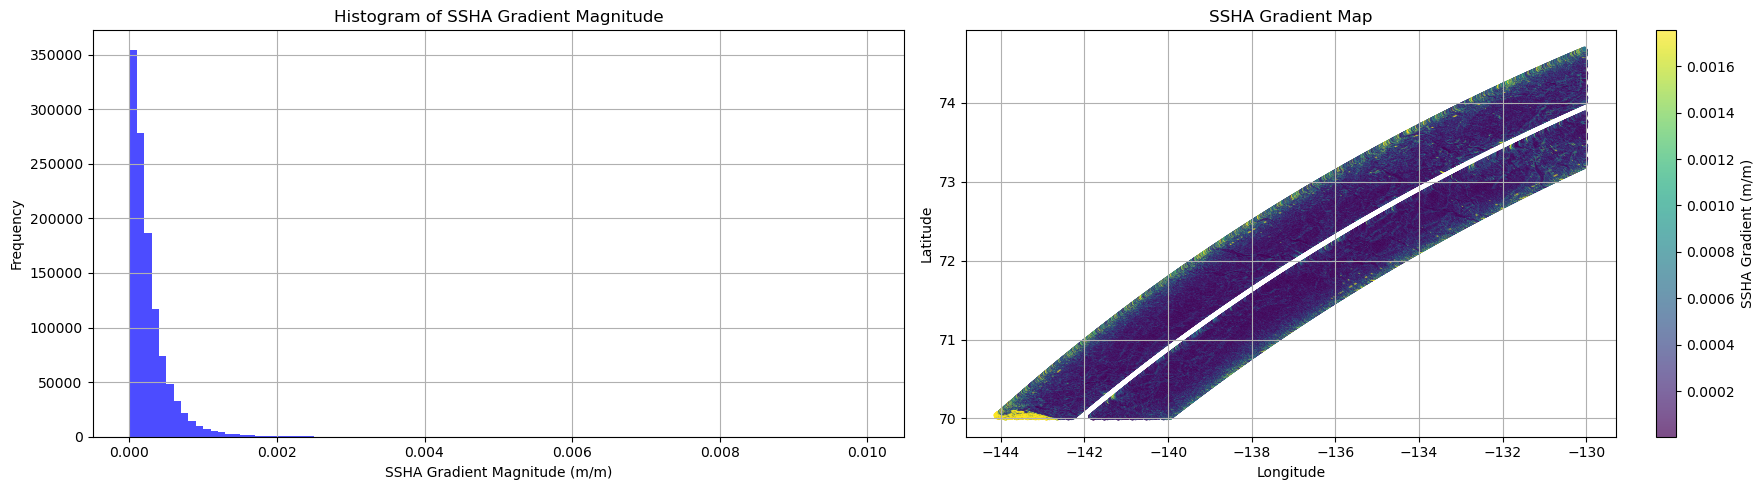

In [58]:

# Example assumes you have arrays: slope, lon, lat (all same shape)
slope_flat = slope.values.flatten()
lon_flat = lon2d.values.flatten()
lat_flat = lat2d.values.flatten()

# Mask invalids
mask = np.isfinite(slope_flat) & np.isfinite(lon_flat) & np.isfinite(lat_flat)
slope_flat = slope_flat[mask]
lon_flat = lon_flat[mask]
lat_flat = lat_flat[mask]

# Create figure with 2 subplots
fig, axes = plt.subplots(1, 2, figsize=(18, 5))

# --- Histogram ---
axes[0].hist(slope_flat, bins=100, color='blue', alpha=0.7, range=(0, 0.01))
axes[0].set_xlabel('SSHA Gradient Magnitude (m/m)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Histogram of SSHA Gradient Magnitude')
axes[0].grid(True)

# --- Scatter plot ---
vmin,vmax = np.percentile(slope_flat, [1, 99])
sc = axes[1].scatter(lon_flat, lat_flat, c=slope_flat, s=5, cmap='viridis', alpha=0.7, vmin=vmin, vmax=vmax)
axes[1].set_xlabel('Longitude')
axes[1].set_ylabel('Latitude')
axes[1].set_title('SSHA Gradient Map')
axes[1].grid(True)
plt.colorbar(sc, ax=axes[1], label='SSHA Gradient (m/m)')

plt.tight_layout()
plt.show()


/tmp/ipykernel_71391/3714981695.py:71: RuntimeWarning: invalid value encountered in log
  c=np.log(unsmoothed_ds["sig0_karin_2"].values),


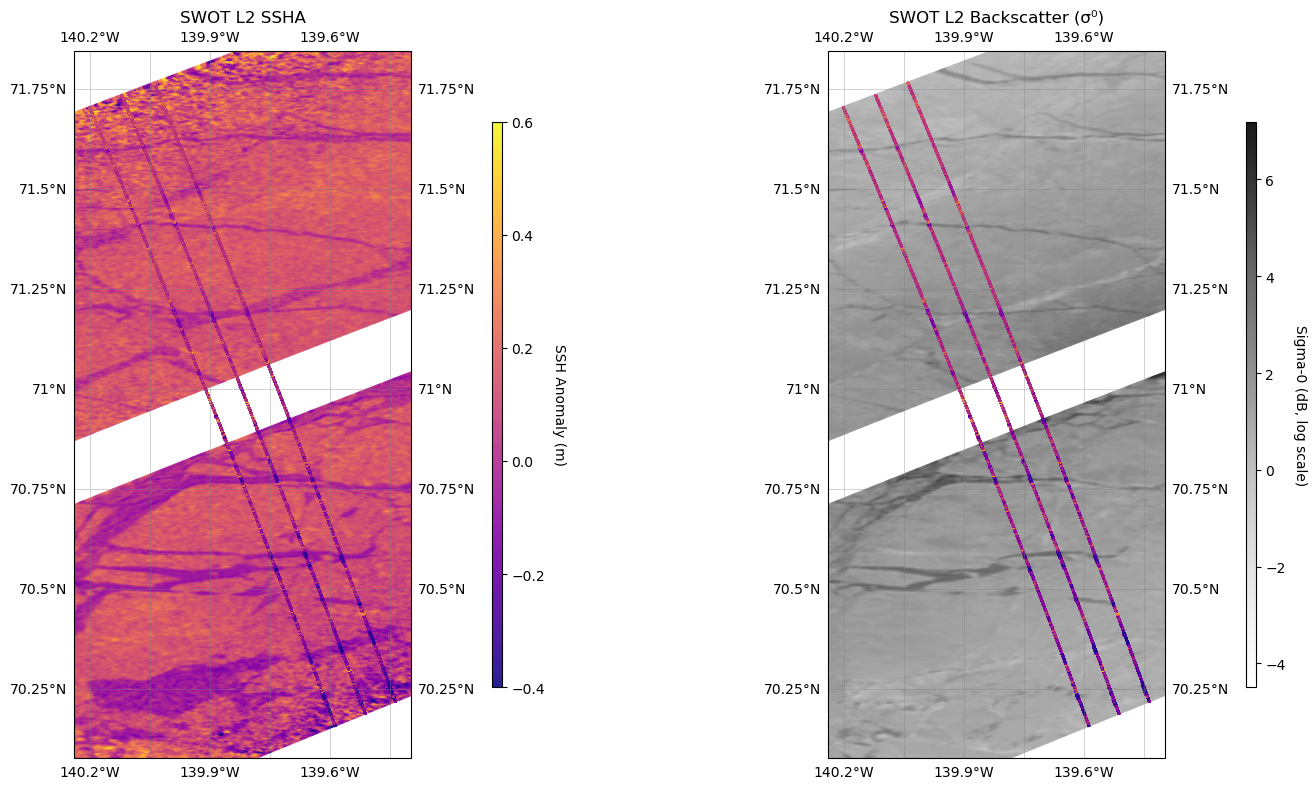

In [65]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np

# Compute extent from ICESat-2 track (+ small margin)
lat_is2 = colocated_tracks["latitude"].values
lon_is2 = colocated_tracks["longitude"].values

lat_min, lat_max = np.nanmin(lat_is2), np.nanmax(lat_is2)
lon_min, lon_max = np.nanmin(lon_is2), np.nanmax(lon_is2)

# Add small margin (in degrees)
lat_pad = (lat_max - lat_min) * 0.05
lon_pad = (lon_max - lon_min) * 0.05
extent = [lon_min - lon_pad, lon_max + lon_pad, lat_min - lat_pad, lat_max + lat_pad]

# -------------------------------------------------------------------------
# Create figure with 2 subplots
fig, (ax1, ax2) = plt.subplots(
    1, 2, figsize=(16, 8), subplot_kw={'projection': ccrs.PlateCarree()}, sharey=True
)

# -------------------------------------------------------------------------
# --- PLOT 1: SWOT SSHA ---
# -------------------------------------------------------------------------
ax1.set_extent(extent)
ax1.coastlines(resolution='110m')
ax1.add_feature(cfeature.LAND, facecolor='lightgray')
ax1.add_feature(cfeature.OCEAN, facecolor='white')
ax1.add_feature(cfeature.BORDERS, linestyle=':')
ax1.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5)

# SWOT SSHA
im1 = ax1.scatter(
    unsmoothed_ds['longitude'].values,
    unsmoothed_ds['latitude'].values,
    c=unsmoothed_ds["ssha_HR"].values,
    s=1.4, cmap="plasma", vmin=-0.4, vmax=0.6, alpha=0.9,
    transform=ccrs.PlateCarree()
)

# ICESat-2 track
ax1.scatter(
    lon_is2[::20],
    lat_is2[::20],
    c=colocated_tracks["ssha_smoothed"].values[::20],
    s=0.5, cmap="plasma", vmin=-0.4, vmax=0.6,
    transform=ccrs.PlateCarree()
)

# Colorbar
cbar1 = plt.colorbar(im1, ax=ax1, orientation='vertical', pad=0.1, aspect=60, shrink=0.8)
cbar1.set_label("SSH Anomaly (m)", rotation=270, labelpad=15)
ax1.set_title("SWOT L2 SSHA")

# -------------------------------------------------------------------------
# --- PLOT 2: SWOT σ⁰ (sig0_karin_2) ---
# -------------------------------------------------------------------------
ax2.set_extent(extent)
ax2.coastlines(resolution='110m')
ax2.add_feature(cfeature.LAND, facecolor='lightgray')
ax2.add_feature(cfeature.OCEAN, facecolor='white')
ax2.add_feature(cfeature.BORDERS, linestyle=':')
ax2.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5)

# SWOT backscatter (log-scaled)
im2 = ax2.scatter(
    unsmoothed_ds['longitude'].values,
    unsmoothed_ds['latitude'].values,
    c=np.log(unsmoothed_ds["sig0_karin_2"].values),
    s=1.4, cmap="Greys", alpha=0.9,
    transform=ccrs.PlateCarree()
)

# ICESat-2 track overlay
ax2.scatter(
    lon_is2[::20],
    lat_is2[::20],
    c=colocated_tracks["ssha_smoothed"].values[::20],
    s=0.5, cmap="plasma", vmin=-0.4, vmax=0.6,
    transform=ccrs.PlateCarree()
)

# Colorbar
cbar2 = plt.colorbar(im2, ax=ax2, orientation='vertical', pad=0.1, aspect=60, shrink=0.8)
cbar2.set_label("Sigma-0 (dB, log scale)", rotation=270, labelpad=15)
ax2.set_title("SWOT L2 Backscatter (σ⁰)")

# -------------------------------------------------------------------------
plt.tight_layout()
plt.show()


/tmp/ipykernel_71391/3318894642.py:5: RuntimeWarning: invalid value encountered in log
  sig0 = np.log(ds_copy["sig0_karin_2"].values)


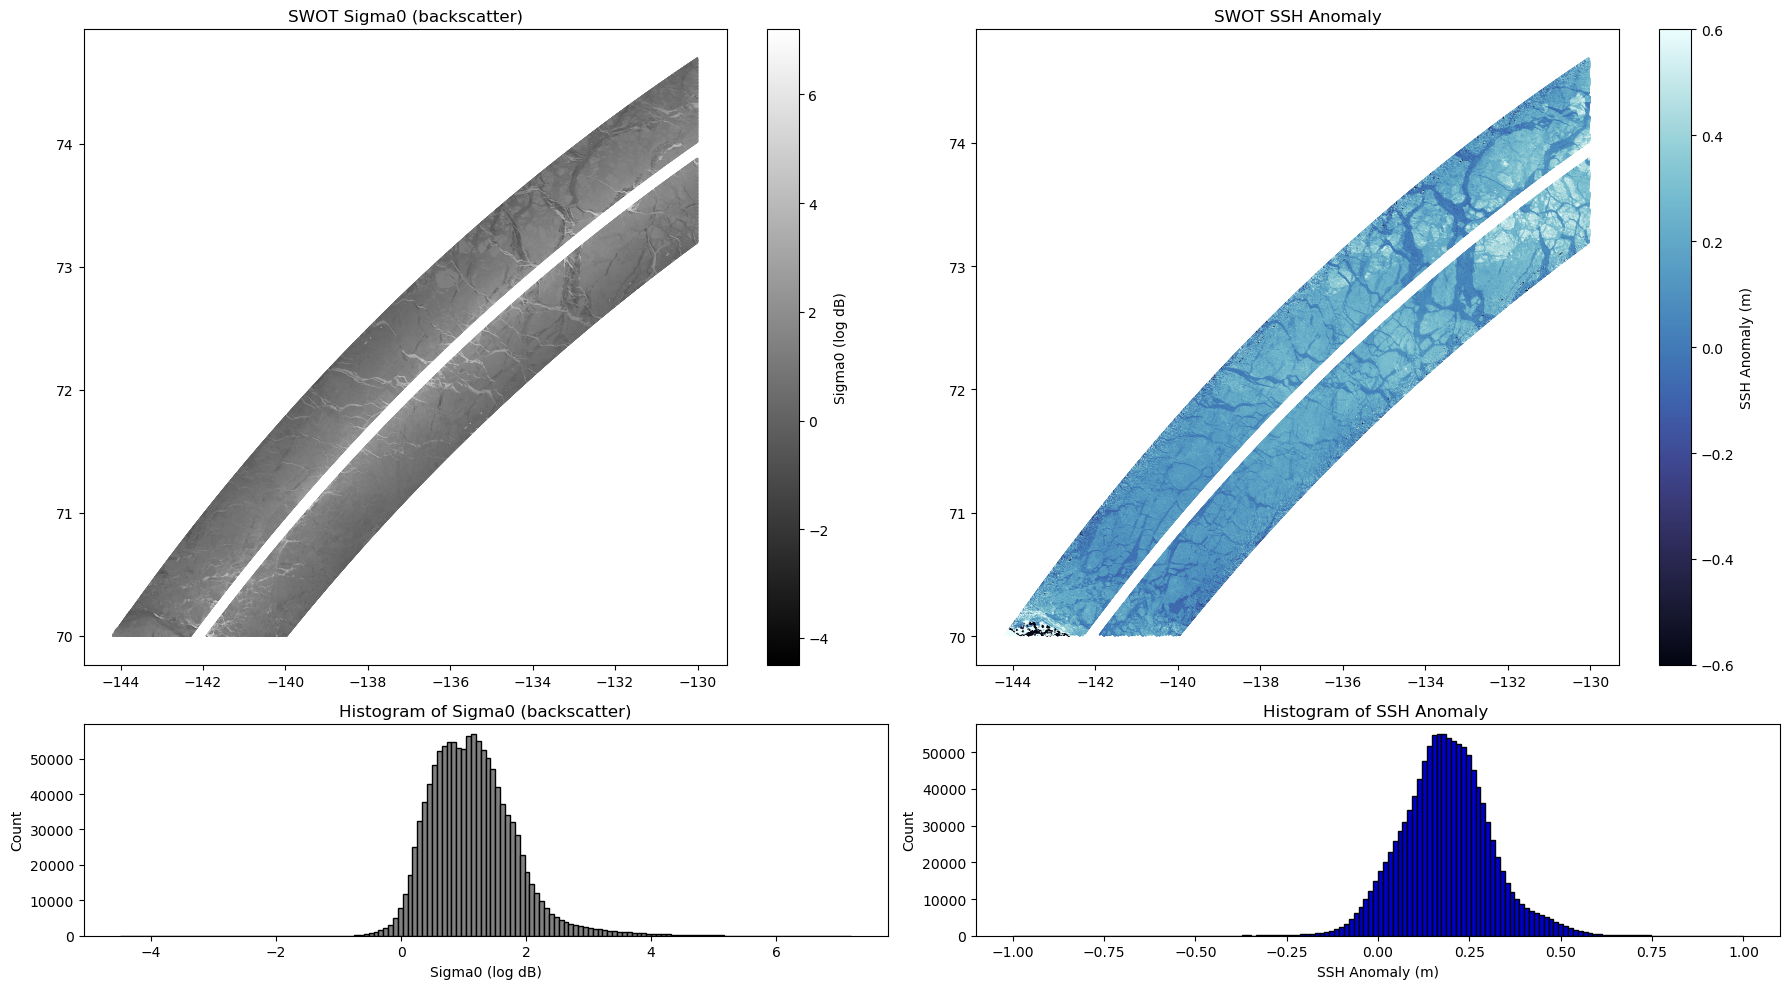

In [68]:

#copy of the ds 
ds_copy = unsmoothed_ds.copy()

# Prepare variables
sig0 = np.log(ds_copy["sig0_karin_2"].values)
ssha_HR = ds_copy["ssha_HR"].values 
lon = ds_copy["longitude"].values
lat = ds_copy["latitude"].values

fig = plt.figure(figsize=(18, 10))
gs = fig.add_gridspec(2, 2, height_ratios=[3, 1])

# --- Top-left: Sigma0 Map ---
ax1 = fig.add_subplot(gs[0, 0])

sc1 = ax1.scatter(lon, lat, c=sig0,s=.1, cmap='gray')
ax1.set_title('SWOT Sigma0 (backscatter)')
cb1 = fig.colorbar(sc1, ax=ax1, orientation='vertical', label='Sigma0 (log dB)')

# --- Top-right: SSH Map ---
ax2 = fig.add_subplot(gs[0, 1])

sc2 = ax2.scatter(lon, lat, c=ssha_HR, s=.1, cmap=cmo.ice, vmin=-.6, vmax=.6)
ax2.set_title('SWOT SSH Anomaly')
cb2 = fig.colorbar(sc2, ax=ax2, orientation='vertical', label='SSH Anomaly (m)')

# --- Bottom-left: Sigma0 Histogram ---
ax3 = fig.add_subplot(gs[1, 0])
ax3.hist(sig0[~np.isnan(sig0)].flatten(), bins=150, color='gray', edgecolor='black')
ax3.set_title('Histogram of Sigma0 (backscatter)')
ax3.set_xlabel('Sigma0 (log dB)')
ax3.set_ylabel('Count')

# --- Bottom-right: SSH Histogram ---
ax4 = fig.add_subplot(gs[1, 1])
ax4.hist(ssha_HR[~np.isnan(ssha_HR)].flatten(), bins=150, color='mediumblue', edgecolor='black',range=(-1, 1))
ax4.set_title('Histogram of SSH Anomaly ')
ax4.set_xlabel('SSH Anomaly (m)')
ax4.set_ylabel('Count')

plt.tight_layout()
plt.show()


In [ ]:
df_lat_lon = colocated_tracks[colocated_tracks["beam_type"] == "strong"][["longitude", "latitude","ssha_smoothed"]].dropna()
df_lat_lon_downsampled = df_lat_lon[::100]
df_lat_lon_downsampled.to_csv("../data/IS2/is2_downsampled2.csv", index=False)

In [ ]:
# save lat lon from colocated tracks as csv only strong beams

df_lat_lon = colocated_tracks[colocated_tracks["beam_type"] == "strong"][["longitude", "latitude","ssha_smoothed"]].dropna()
df_lat_lon.to_csv("colocated_tracks_lat_lon_smooth.csv", index=False)


In [ ]:
save_field_as_xyz(unsmoothed_ds, "ssha_HR", "../data/xyz/ssha_HR.xyz", clip_range=(-1,1))
save_field_as_xyz( unsmoothed_ds, "ssh_karin_2", "../data/xyz/ssh_karin_2.xyz")
save_field_as_xyz( unsmoothed_ds, "sig0_karin_2", "../data/xyz/sig0_karin_2.xyz",apply_log=True)


Saved to ../data/xyz/ssha_HR.xyz
Saved to ../data/xyz/ssh_karin_2.xyz
Saved to ../data/xyz/sig0_karin_2.xyz
Saved to ../data/xyz/quality_flag.xyz


(         Longitude  Latitude  Value
 0       -149.35057  70.46330   20.0
 1       -148.94482  70.37252   20.0
 2       -148.95158  70.37690   20.0
 3       -148.94625  70.37556   20.0
 4       -148.96355  70.38257   20.0
 ...            ...       ...    ...
 1550030 -130.01252  75.64505   20.0
 1550031 -130.00749  75.64320   20.0
 1550032 -130.00245  75.64134   20.0
 1550033 -130.00542  75.64624   20.0
 1550034 -130.00040  75.64439   20.0
 
 [1550035 rows x 3 columns],
 '../data/xyz/quality_flag.xyz')

In [ ]:
L3_path = ""#gotta find it manually
swot_L3_ds = crop_swot_dataset(xr.open_dataset(L3_path))
swot_L3_ds['quality_flag'] = swot_L3_ds['quality_flag'].where(
    swot_L3_ds['quality_flag'].isin([0,18, 19, 20])
)


# Create figure and subplots with shared projection
fig, (ax1, ax2, ax3) = plt.subplots(
    1, 3, figsize=(24, 8), subplot_kw={'projection': ccrs.PlateCarree()}, sharey=True
)

# Set common map extent
# Compute extent from ICESat-2 track (+ small margin)
lat_is2 = colocated_tracks["latitude"].values
lon_is2 = colocated_tracks["longitude"].values

lat_min, lat_max = np.nanmin(lat_is2), np.nanmax(lat_is2)
lon_min, lon_max = np.nanmin(lon_is2), np.nanmax(lon_is2)

# Add small margin (in degrees)
lat_pad = (lat_max - lat_min) * 0.05
lon_pad = (lon_max - lon_min) * 0.05
extent = [lon_min - lon_pad, lon_max + lon_pad, lat_min - lat_pad, lat_max + lat_pad]

### --- PLOT 1: SWOT SSHA ---
ax1.set_extent(extent)
ax1.coastlines(resolution='110m')
ax1.add_feature(cfeature.LAND, facecolor='lightgray')
ax1.add_feature(cfeature.OCEAN, facecolor='white')
ax1.add_feature(cfeature.BORDERS, linestyle=':')
ax1.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5)

# SWOT SSHA
im1 = ax1.scatter(
    unsmoothed_ds['longitude'].values,
    unsmoothed_ds['latitude'].values,
    c=unsmoothed_ds["ssha_HR"].values,
    s=1.4, cmap="plasma", vmin=-0.4, vmax=0.6, alpha=0.9,
    transform=ccrs.PlateCarree(), label='SWOT SSHA'
)

# ICESat-2
ax1.scatter(
    colocated_tracks['longitude'].values[::20],
    colocated_tracks['latitude'].values[::20],
    c=colocated_tracks["ssha_smoothed"].values[::20],
    s=0.5, cmap="plasma", vmin=-0.4, vmax=0.6,
    transform=ccrs.PlateCarree(), label='ICESat-2 ATL07'
)

cbar1 = plt.colorbar(im1, ax=ax1, orientation='vertical', pad=0.1, aspect=60, shrink=0.8)
cbar1.set_label("SSH Anomaly (m)", rotation=270, labelpad=15)
ax1.set_title("SWOT L2 SSHA")
#ax1.legend(loc='lower left', markerscale=10)

### --- PLOT 2: SWOT sig0_karin_2 ---
ax2.set_extent(extent)
ax2.coastlines(resolution='110m')
ax2.add_feature(cfeature.LAND, facecolor='lightgray')
ax2.add_feature(cfeature.OCEAN, facecolor='white')
ax2.add_feature(cfeature.BORDERS, linestyle=':')
ax2.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5)

# SWOT sig0
im2 = ax2.scatter(
    unsmoothed_ds['longitude'].values,
    unsmoothed_ds['latitude'].values,
    c=np.log(unsmoothed_ds["sig0_karin_2"].values),
    s=1.4, cmap="Grays", alpha=0.9,
    transform=ccrs.PlateCarree(), label='SWOT sig0'
)
cbar2_sig = plt.colorbar(im2, ax=ax2, orientation='vertical', pad=0.1, aspect=60, shrink=0.8)
cbar2_sig.set_label("Sigma-0 (dB)", rotation=270, labelpad=15)
# ICESat-2
im2 = ax2.scatter(
    colocated_tracks['longitude'].values[::20],
    colocated_tracks['latitude'].values[::20],
    c=colocated_tracks["ssha_smoothed"].values[::20],
    s=0.5, cmap="plasma", vmin=-0.4, vmax=0.6,
    transform=ccrs.PlateCarree(), label='ICESat-2 ATL07'
)
#cbar2_is2 = plt.colorbar(im2, ax=ax2, orientation='vertical', pad=0.01, aspect=40)
#cbar2_is2.set_label("SSH Anomaly (m)", rotation=270, labelpad=15)


ax2.set_title("SWOT L2 backscatter")
#ax2.legend(loc='lower left', markerscale=10)

### --- PLOT 3: SWOT Mask ---
ax3.set_extent(extent)
ax3.coastlines(resolution='110m')
ax3.add_feature(cfeature.LAND, facecolor='lightgray')
ax3.add_feature(cfeature.OCEAN, facecolor='white')
ax3.add_feature(cfeature.BORDERS, linestyle=':')
ax3.gridlines(draw_labels=True, linewidth=0.5, alpha=0.5)

# SWOT mask

# Define quality flag values and custom colors

colors = [ '#08306b', '#2171b5',"#98acc2","#edf5f7"]  # beige, gray, blue, dark blue

# Create the colormap and norm
cmap = ListedColormap(colors)
norm = BoundaryNorm([-0.5, 9.5, 18.5, 19.5, 20.5], ncolors=len(colors))

im3 = ax3.scatter(
    swot_L3_ds['longitude'].values,
    swot_L3_ds['latitude'].values,
    c=swot_L3_ds.quality_flag.values,
    s=1.4, cmap=cmap, norm=norm, alpha=0.9,
    transform=ccrs.PlateCarree(), label='SWOT Mask'
)

# ICESat-2
ax3.scatter(
    colocated_tracks['longitude'].values[::20],
    colocated_tracks['latitude'].values[::20],
    c=colocated_tracks["ssha_smoothed"].values[::20],
    s=0.5, cmap="plasma", vmin=-0.4, vmax=0.6,
    transform=ccrs.PlateCarree(), label='ICESat-2 ATL07'
)

cbar3 = plt.colorbar(im3, ax=ax3, orientation='vertical', pad=0.1, aspect=60, shrink=0.8, ticks=[3, 13, 19, 20])
cbar3.set_label("Mask", rotation=270, labelpad=15)
# Set custom text labels for the ticks
cbar3.ax.set_yticklabels([
    "Ocean",
    "Unsure Ocean",
    "Unsure ice",
    "ice"
])
ax3.set_title("SWOT L3 LEGOS Sea Ice Mask")
#ax3.legend(loc='lower left', markerscale=10)

# Final layout
plt.tight_layout()
plt.show()
